In [2]:
import sys
import os

import pandas as pd
import numpy as np
import numdifftools as ndt
import statsmodels.api as sm

import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')
import matplotlib.cm as cm
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from matplotlib.dates import DateFormatter

from scipy.stats import gamma
from scipy.stats import norm
from scipy.stats import truncnorm
from scipy.stats import vonmises
from scipy.stats import multivariate_normal
from scipy.stats import gaussian_kde
from scipy.stats import circstd
from scipy.special import iv
from scipy.special import expit
from scipy.special import logit
from scipy.special import logsumexp
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
from scipy.optimize import LinearConstraint
from scipy.signal import convolve
from scipy.interpolate import interp1d
from scipy.linalg import block_diag

from datetime import datetime
from time import gmtime, strftime

from math import isclose
from copy import deepcopy
from itertools import product
import importlib
import time
import pickle
import random

import helper_funcs
import HHMM
import optimizor
import stoch_optimizor

from helper_funcs import eta_2_log_Gamma
from helper_funcs import log_Gamma_2_eta
from helper_funcs import eta0_2_log_delta
from helper_funcs import log_delta_2_eta0
from helper_funcs import logdotexp

# Load in Data

In [2]:
df = pd.read_csv("../../dat/Final_Data_Beth_fine.csv")
df_coarse = pd.read_csv("../../dat/Final_Data_Beth.csv")

df["stime"] = pd.to_datetime(df["stime"])
df["etime"] = pd.to_datetime(df["etime"])

# add dive duration
coarse_features = ['diveDuration']

df = df.merge(df_coarse[['divenum']+coarse_features],
              on = 'divenum',
              how = 'left')

for feature in coarse_features:
    df.loc[df.duplicated(['ID','divenum']),feature] = np.nan

df["w_low"] = np.log(df["w_low"])
df["w_high"] = np.log(df["w_high"])
#df['diveDuration'] = np.exp(df['diveDuration'])

df["delt_d"] = df["ad"].diff()
df["elev"] = -df["ad"]

#df = df[df["ID"] == "D26"]#.iloc[0:1000]
df = df.reset_index()

#jump_inds = range(len(df))
jump_inds = df.index[~np.isnan(df["diveDuration"])].to_list()

# make the delta_d nan at the start of each dive
df["delt_d"].iloc[jump_inds] = np.nan

# add edives to df
edives = [False]*len(df)
for ind in jump_inds[1:]:
    if ind-1 not in jump_inds[1:]:
        edives[ind-1] = True
edives[-1] = True
df["e_dive"] = edives

/var/folders/1p/g1nbxjc540sd1x_r8wk3ljm00000gn/T/ipykernel_7532/313830914.py:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../../dat/Final_Data_Beth_fine.csv")
/var/folders/1p/g1nbxjc540sd1x_r8wk3ljm00000gn/T/ipykernel_7532/313830914.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["delt_d"].iloc[jump_inds] = np.nan


In [3]:
df['divenum']

0           1
1           1
2           1
3           1
4           1
         ... 
89457    5857
89458    5858
89459    5858
89460    5858
89461    5858
Name: divenum, Length: 89462, dtype: int64

In [4]:
# populate a data object
data = []

initial_ts = [0]
final_ts = []

features = ['delt_d','e_dive']#'diveDuration','aw1','aw2','aw3','w_low']

means = {feature: df[feature].mean() for feature in features}
stds = {feature: df[feature].std() for feature in features}

for feature in ['delt_d']:#['aw1','aw2','aw3']:
    df[feature] = (df[feature] - means[feature])/stds[feature]

#for feature in ['diveDuration','w_low']:
#    df[feature] = df[feature]/stds[feature]

for t,row in enumerate(df.iterrows()):
    
    if t != 0 and df.iloc[t]["ID"] != df.iloc[t-1]["ID"]:
        final_ts.append(t-1)
        initial_ts.append(t)
     
    data.append({feature : row[1][feature] for feature in features})

final_ts.append(t)

initial_ts = np.array(initial_ts)
final_ts = np.array(final_ts)

print(initial_ts)
print(final_ts)

[    0  5724 16321 45396 54963 72217 79896 87293]
[ 5723 16320 45395 54962 72216 79895 87292 89461]


In [5]:
means

{'delt_d': -0.021355359366297417, 'e_dive': 0.0620375131340681}

In [6]:
stds

{'delt_d': 0.9783616413367805, 'e_dive': 0.24122502054409917}

In [7]:
'''
### features of data ###
features = {'delt_d'            : {'f'           : 'normal',
                                   'lower_bound' : None,
                                   'upper_bound' : None,
                                   'share_coarse': True,
                                   'share_fine'  : False}}

### load in data ###
df = pd.read_csv("../../dat/Final_Data_Beth_fine.csv")
df["w_low"] = np.log(df["w_low"])
df["w_high"] = np.log(df["w_high"])
df["delt_d"] = df["ad"].diff()

whales = pd.unique(df.ID)

# only take whale I107
#whales = ["I145"]
#df = df[df["ID"].isin(whales)]

# convert times
df["stime"] = pd.to_datetime(df["stime"])
df["etime"] = pd.to_datetime(df["etime"])

# populate a data object
data = []

initial_ts = [0]
final_ts = []

for t,row in enumerate(df.iterrows()):

    if t != 0 and df.iloc[t]["ID"] != df.iloc[t-1]["ID"]:
        final_ts.append(t-1)
        initial_ts.append(t)

    data.append({#"w_low"     : row[1]["w_low"],
                 "delt_d"    : row[1]["delt_d"]})

final_ts.append(t)

initial_ts = np.array(initial_ts)
final_ts = np.array(final_ts)

T = len(data)
K = [2,3]
'''

'\n### features of data ###\nfeatures = {\'delt_d\'            : {\'f\'           : \'normal\',\n                                   \'lower_bound\' : None,\n                                   \'upper_bound\' : None,\n                                   \'share_coarse\': True,\n                                   \'share_fine\'  : False}}\n\n### load in data ###\ndf = pd.read_csv("../../dat/Final_Data_Beth_fine.csv")\ndf["w_low"] = np.log(df["w_low"])\ndf["w_high"] = np.log(df["w_high"])\ndf["delt_d"] = df["ad"].diff()\n\nwhales = pd.unique(df.ID)\n\n# only take whale I107\n#whales = ["I145"]\n#df = df[df["ID"].isin(whales)]\n\n# convert times\ndf["stime"] = pd.to_datetime(df["stime"])\ndf["etime"] = pd.to_datetime(df["etime"])\n\n# populate a data object\ndata = []\n\ninitial_ts = [0]\nfinal_ts = []\n\nfor t,row in enumerate(df.iterrows()):\n\n    if t != 0 and df.iloc[t]["ID"] != df.iloc[t-1]["ID"]:\n        final_ts.append(t-1)\n        initial_ts.append(t)\n\n    data.append({#"w_low"

# Load in Whale Data

In [8]:
raw_df = pd.read_csv("../../dat/Final_rawData_Beth.csv", 
                      usecols = ["Time","p","head","pitch","roll","divenum","w_low","w_high","ID"],
                      low_memory = True)

In [9]:
raw_df["Elevation"] = -raw_df["p"]
raw_df["Time"] = pd.to_datetime(raw_df["Time"])
raw_df = raw_df.reset_index(drop=True)

A100


/var/folders/1p/g1nbxjc540sd1x_r8wk3ljm00000gn/T/ipykernel_7532/232567263.py:10: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  plt.locator_params(axis='x', nbins=10)


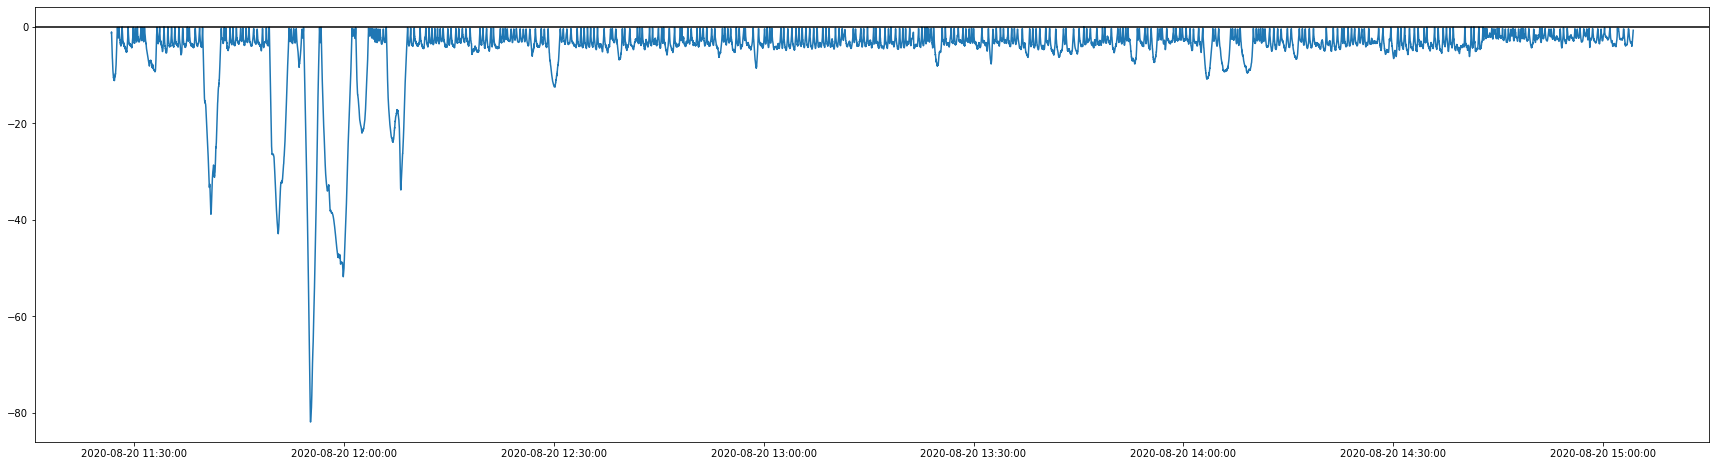

A113


/var/folders/1p/g1nbxjc540sd1x_r8wk3ljm00000gn/T/ipykernel_7532/232567263.py:10: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  plt.locator_params(axis='x', nbins=10)


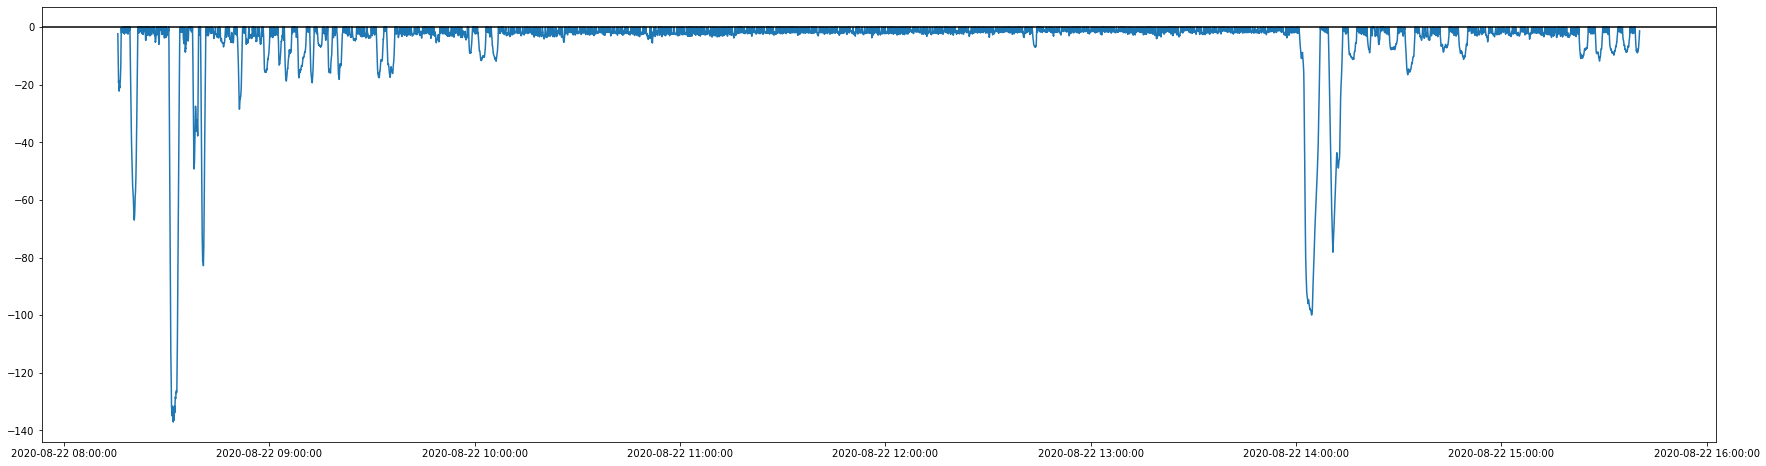

D21


/var/folders/1p/g1nbxjc540sd1x_r8wk3ljm00000gn/T/ipykernel_7532/232567263.py:10: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  plt.locator_params(axis='x', nbins=10)


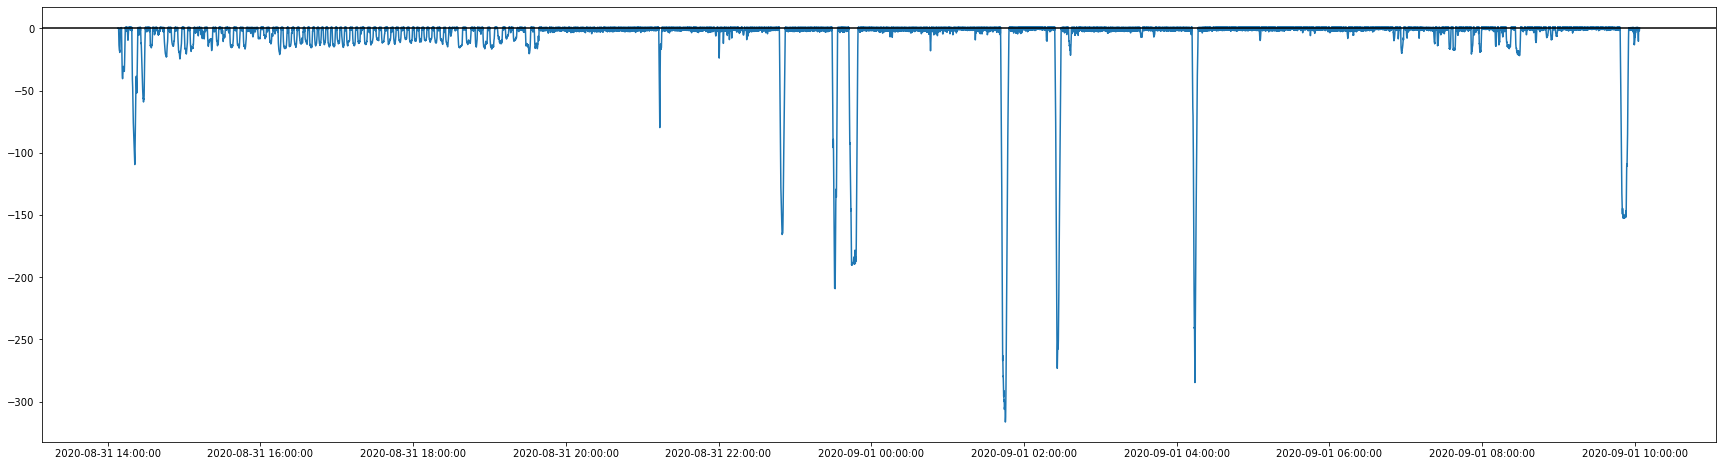

D26


/var/folders/1p/g1nbxjc540sd1x_r8wk3ljm00000gn/T/ipykernel_7532/232567263.py:10: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  plt.locator_params(axis='x', nbins=10)


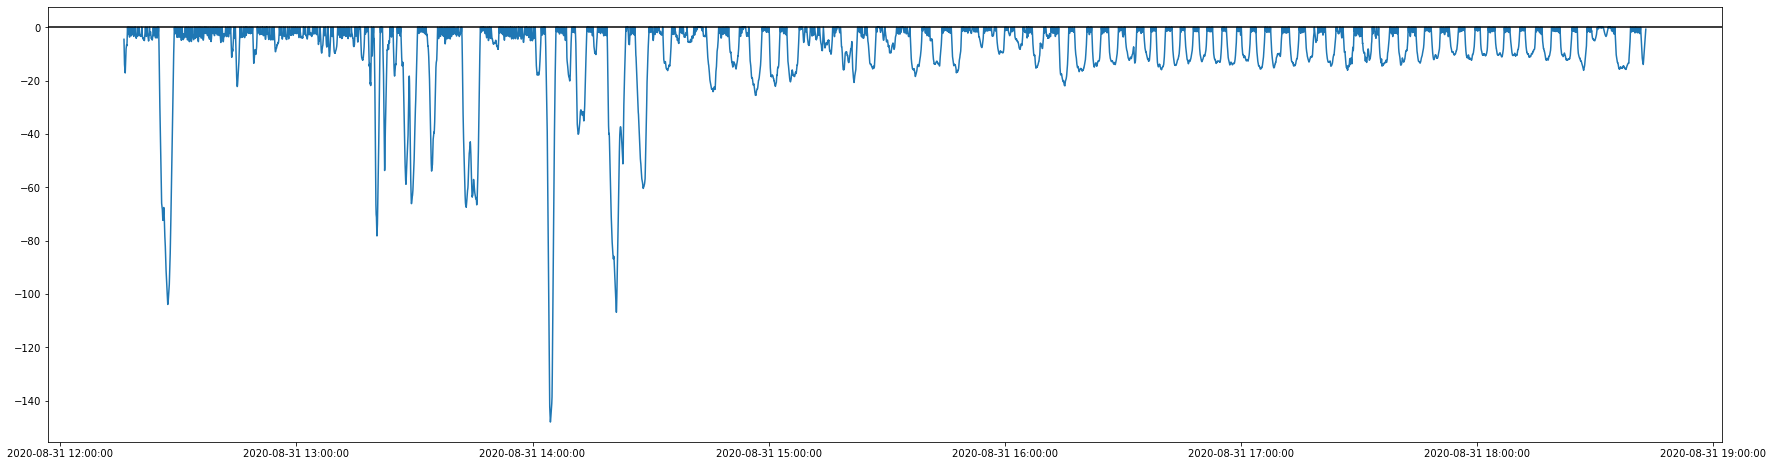

I107


/var/folders/1p/g1nbxjc540sd1x_r8wk3ljm00000gn/T/ipykernel_7532/232567263.py:10: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  plt.locator_params(axis='x', nbins=10)


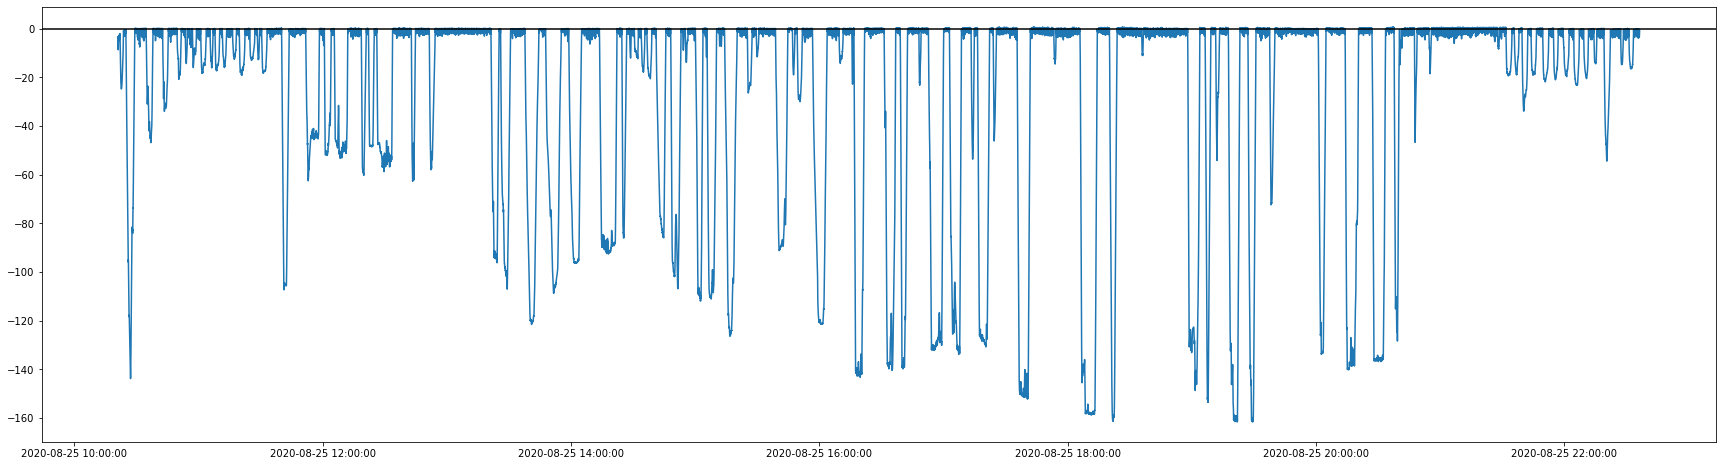

I145


/var/folders/1p/g1nbxjc540sd1x_r8wk3ljm00000gn/T/ipykernel_7532/232567263.py:10: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  plt.locator_params(axis='x', nbins=10)


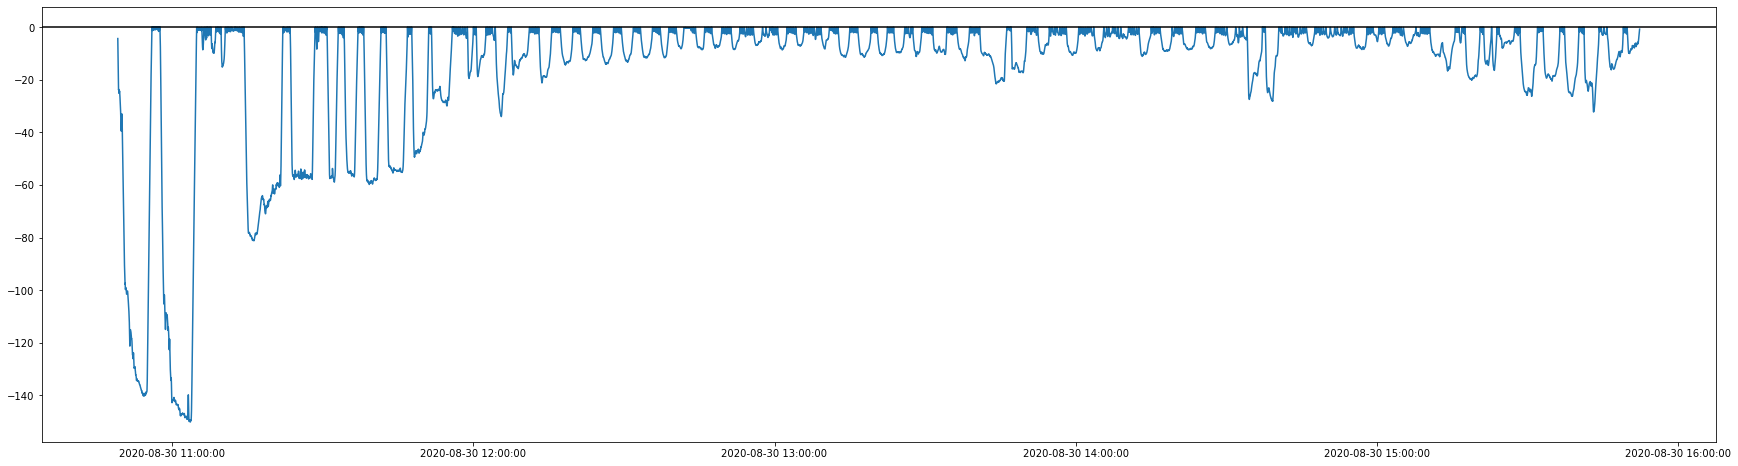

R48


/var/folders/1p/g1nbxjc540sd1x_r8wk3ljm00000gn/T/ipykernel_7532/232567263.py:10: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  plt.locator_params(axis='x', nbins=10)


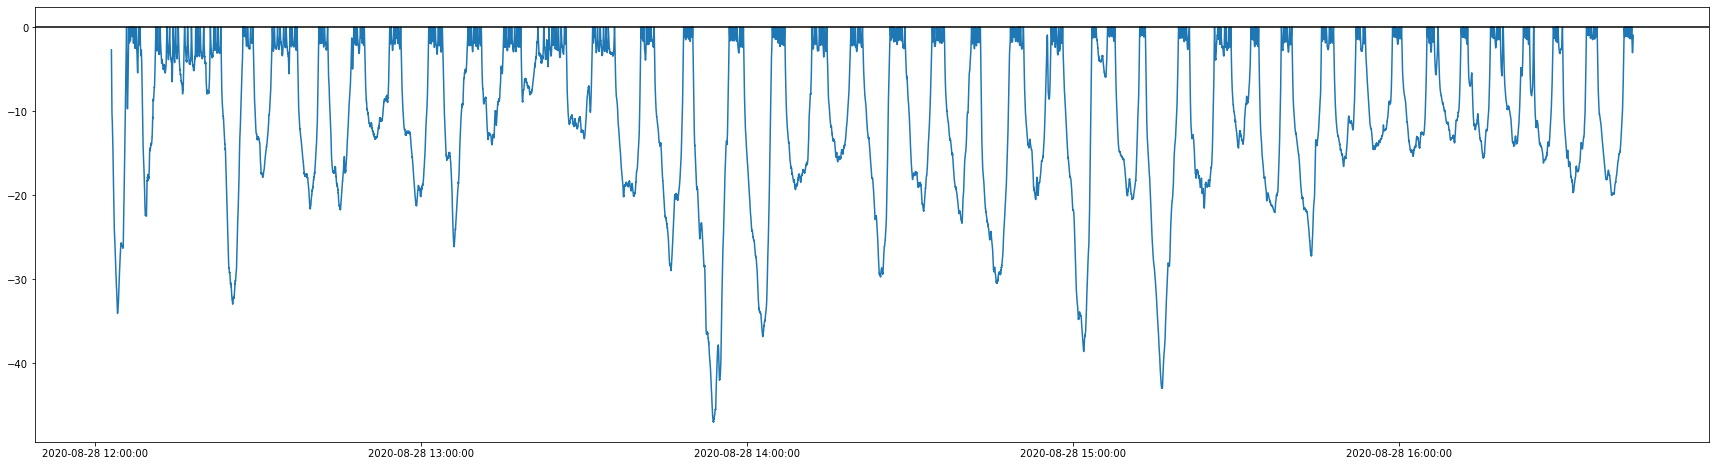

R58


/var/folders/1p/g1nbxjc540sd1x_r8wk3ljm00000gn/T/ipykernel_7532/232567263.py:10: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  plt.locator_params(axis='x', nbins=10)


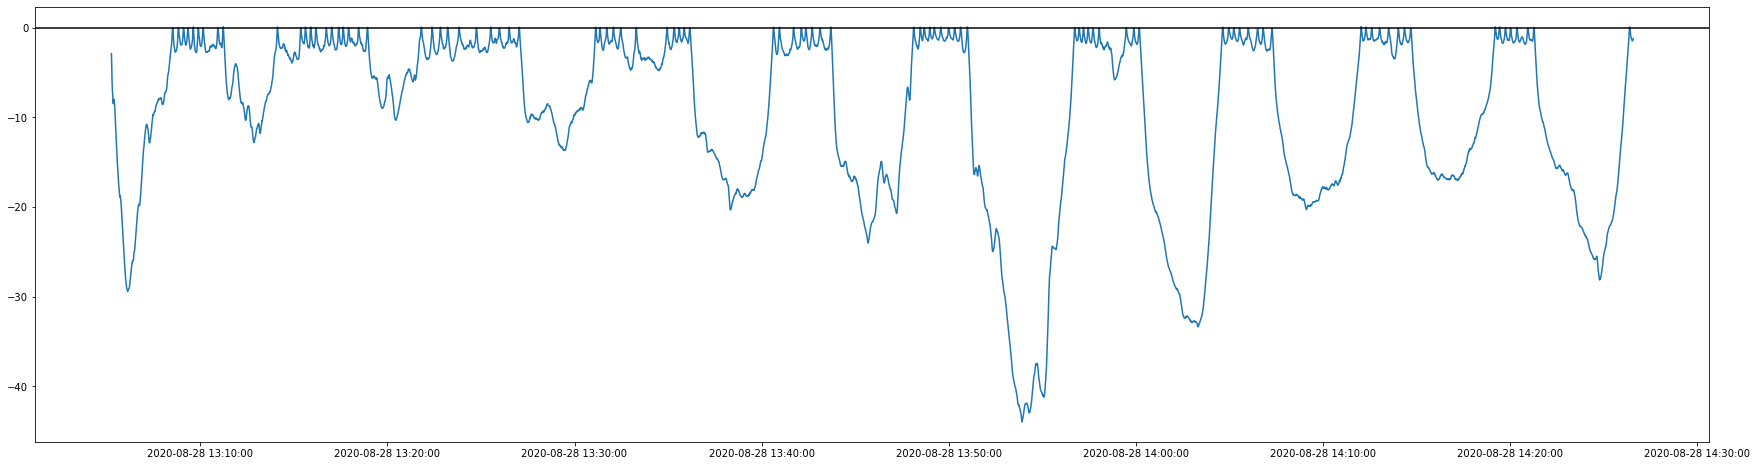

In [10]:
whales = pd.unique(df.ID)
for whale in whales:
    print(whale)
    stime = df.loc[df["ID"].isin([whale]),"stime"].min()
    etime = df.loc[df["ID"].isin([whale]),"etime"].max()
    plt.figure(figsize=(30,8))
    inds = (raw_df["Time"] > stime) & (raw_df["Time"] < etime) & (raw_df["ID"] == whale)
    plt.plot(raw_df[inds].iloc[::50]["Time"],
             raw_df[inds].iloc[::50]["Elevation"])
    plt.locator_params(axis='x', nbins=10)
    plt.axhline(0,color='k')
    plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d %H:%M:%S'))
    plt.show()

# Load in the HMM

In [11]:
date = "2023-04-14"

param_folder = "/Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/updown/" + date
plot_folder = "/Users/evsi8432/Documents/Research/sublinear-HMM-inference/plt/case_study/updown/" + date

if not os.path.isdir(plot_folder):
    os.mkdir(plot_folder)
    
methods = ["control","BFGS","SAGA","SVRG","GD","CG"]

K = [3,3]

partial_Es = [0.0,0.5,1.0]

tol = 1e-3

optims = {}
times_to_converge = {}
epochs_to_converge = {}
lls = {}

In [12]:
for method in methods:
    for partial_E in partial_Es:
        if method in ["BFGS","CG","GD","control"] and partial_E > 0.0:
            pass
        else:
            
            # get best ll
            best_ll = -np.infty
            #best_fname = param_folder + "/case_study_updown_K-%d-%d_%s_%.1f_%03d" % (K[0],K[1],method,partial_E,0)
            best_fname = param_folder + "/K-%d-%d_%s_%.1f_%03d" % (K[0],K[1],method,partial_E,0)
            
            # initialize lls
            lls[(method,partial_E)] = []
            
            # initialize epochs
            epochs_to_converge[(method,partial_E)] = []
            
            # initialize times
            times_to_converge[(method,partial_E)] = []
            
            for rand_seed in range(50):
                
                fname = param_folder + "/case_study_updown_K-%d-%d_%s_%.1f_%03d" % (K[0],K[1],method,partial_E,rand_seed)
                #fname = param_folder + "/K-%d-%d_%s_%.1f_%03d" % (K[0],K[1],method,partial_E,rand_seed)
                
                #try:
                with open(fname, 'rb') as f:
                    optim = pickle.load(f)
                print("loaded file %s" % fname)
                #except:
                #    print("file %s does not exist" % fname)
                #    continue
                
                # check for some issue (likely nan in theta)
                if len(optim.time_trace) == 0:
                    print("file %s didn't optimize." % fname)
                    continue
                    
                
                # get convergence ind
                converge_ind = min(np.where(np.array(optim.grad_norm_trace) < tol)[0],
                                   default=len(optim.grad_norm_trace)-1)
                
                epochs_to_converge[(method,partial_E)].append(optim.epoch_trace[converge_ind])
                times_to_converge[(method,partial_E)].append(optim.time_trace[converge_ind])
                lls[(method,partial_E)].append(optim.log_like_trace[converge_ind])
                
                if optim.log_like_trace[-1] > best_ll:    
                    optims[(method,partial_E)] = optim
                    best_fname = fname
                    best_ll = optim.log_like_trace[-1]
                    
            print(best_fname)

loaded file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/updown/2023-04-14/case_study_updown_K-3-3_control_0.0_000
loaded file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/updown/2023-04-14/case_study_updown_K-3-3_control_0.0_001
loaded file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/updown/2023-04-14/case_study_updown_K-3-3_control_0.0_002
loaded file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/updown/2023-04-14/case_study_updown_K-3-3_control_0.0_003
loaded file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/updown/2023-04-14/case_study_updown_K-3-3_control_0.0_004
loaded file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/updown/2023-04-14/case_study_updown_K-3-3_control_0.0_005
loaded file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/updown/2023-04-14/case_study_

loaded file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/updown/2023-04-14/case_study_updown_K-3-3_BFGS_0.0_005
loaded file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/updown/2023-04-14/case_study_updown_K-3-3_BFGS_0.0_006
loaded file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/updown/2023-04-14/case_study_updown_K-3-3_BFGS_0.0_007
loaded file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/updown/2023-04-14/case_study_updown_K-3-3_BFGS_0.0_008
loaded file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/updown/2023-04-14/case_study_updown_K-3-3_BFGS_0.0_009
loaded file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/updown/2023-04-14/case_study_updown_K-3-3_BFGS_0.0_010
loaded file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/updown/2023-04-14/case_study_updown_K-3-3_BFGS_

loaded file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/updown/2023-04-14/case_study_updown_K-3-3_SAGA_0.0_014
loaded file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/updown/2023-04-14/case_study_updown_K-3-3_SAGA_0.0_015
loaded file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/updown/2023-04-14/case_study_updown_K-3-3_SAGA_0.0_016
loaded file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/updown/2023-04-14/case_study_updown_K-3-3_SAGA_0.0_017
loaded file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/updown/2023-04-14/case_study_updown_K-3-3_SAGA_0.0_018
loaded file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/updown/2023-04-14/case_study_updown_K-3-3_SAGA_0.0_019
loaded file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/updown/2023-04-14/case_study_updown_K-3-3_SAGA_

loaded file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/updown/2023-04-14/case_study_updown_K-3-3_SAGA_0.5_023
loaded file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/updown/2023-04-14/case_study_updown_K-3-3_SAGA_0.5_024
loaded file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/updown/2023-04-14/case_study_updown_K-3-3_SAGA_0.5_025
loaded file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/updown/2023-04-14/case_study_updown_K-3-3_SAGA_0.5_026
loaded file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/updown/2023-04-14/case_study_updown_K-3-3_SAGA_0.5_027
loaded file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/updown/2023-04-14/case_study_updown_K-3-3_SAGA_0.5_028
loaded file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/updown/2023-04-14/case_study_updown_K-3-3_SAGA_

loaded file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/updown/2023-04-14/case_study_updown_K-3-3_SAGA_1.0_031
loaded file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/updown/2023-04-14/case_study_updown_K-3-3_SAGA_1.0_032
loaded file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/updown/2023-04-14/case_study_updown_K-3-3_SAGA_1.0_033
loaded file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/updown/2023-04-14/case_study_updown_K-3-3_SAGA_1.0_034
loaded file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/updown/2023-04-14/case_study_updown_K-3-3_SAGA_1.0_035
loaded file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/updown/2023-04-14/case_study_updown_K-3-3_SAGA_1.0_036
loaded file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/updown/2023-04-14/case_study_updown_K-3-3_SAGA_

loaded file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/updown/2023-04-14/case_study_updown_K-3-3_SVRG_0.0_040
loaded file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/updown/2023-04-14/case_study_updown_K-3-3_SVRG_0.0_041
loaded file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/updown/2023-04-14/case_study_updown_K-3-3_SVRG_0.0_042
loaded file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/updown/2023-04-14/case_study_updown_K-3-3_SVRG_0.0_043
loaded file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/updown/2023-04-14/case_study_updown_K-3-3_SVRG_0.0_044
loaded file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/updown/2023-04-14/case_study_updown_K-3-3_SVRG_0.0_045
loaded file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/updown/2023-04-14/case_study_updown_K-3-3_SVRG_

loaded file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/updown/2023-04-14/case_study_updown_K-3-3_SVRG_0.5_047
loaded file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/updown/2023-04-14/case_study_updown_K-3-3_SVRG_0.5_048
loaded file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/updown/2023-04-14/case_study_updown_K-3-3_SVRG_0.5_049
/Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/updown/2023-04-14/case_study_updown_K-3-3_SVRG_0.5_027
loaded file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/updown/2023-04-14/case_study_updown_K-3-3_SVRG_1.0_000
loaded file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/updown/2023-04-14/case_study_updown_K-3-3_SVRG_1.0_001
loaded file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/updown/2023-04-14/case_study_updown_K-3-3_SVRG_1.0_002
load

loaded file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/updown/2023-04-14/case_study_updown_K-3-3_GD_0.0_005
loaded file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/updown/2023-04-14/case_study_updown_K-3-3_GD_0.0_006
loaded file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/updown/2023-04-14/case_study_updown_K-3-3_GD_0.0_007
loaded file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/updown/2023-04-14/case_study_updown_K-3-3_GD_0.0_008
loaded file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/updown/2023-04-14/case_study_updown_K-3-3_GD_0.0_009
loaded file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/updown/2023-04-14/case_study_updown_K-3-3_GD_0.0_010
loaded file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/updown/2023-04-14/case_study_updown_K-3-3_GD_0.0_011
loaded

loaded file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/updown/2023-04-14/case_study_updown_K-3-3_CG_0.0_017
loaded file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/updown/2023-04-14/case_study_updown_K-3-3_CG_0.0_018
loaded file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/updown/2023-04-14/case_study_updown_K-3-3_CG_0.0_019
loaded file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/updown/2023-04-14/case_study_updown_K-3-3_CG_0.0_020
loaded file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/updown/2023-04-14/case_study_updown_K-3-3_CG_0.0_021
loaded file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/updown/2023-04-14/case_study_updown_K-3-3_CG_0.0_022
loaded file /Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/updown/2023-04-14/case_study_updown_K-3-3_CG_0.0_023
loaded

In [13]:
max_ll = -np.infty
for key,optim in optims.items():
    print(key)
    print(optim.log_like_trace[-1])
    print("")
    if optim.log_like_trace[-1] > max_ll:
        self = optim
        max_ll = optim.log_like_trace[-1]

('control', 0.0)
-0.48120538366137316

('BFGS', 0.0)
-0.4810617223844701

('SAGA', 0.0)
-0.48121429194790716

('SAGA', 0.5)
-0.4812053361526417

('SAGA', 1.0)
-0.4809909563185551

('SVRG', 0.0)
-0.48120534742637955

('SVRG', 0.5)
-0.48120535864043396

('SVRG', 1.0)
-0.4812353261008536

('GD', 0.0)
-0.601657911264172

('CG', 0.0)
-0.4869439144839029



In [14]:
for t,datum in enumerate(data):
    if np.isnan(datum['delt_d']) and datum['e_dive']:
        print(t)
        print(datum)

# Repopulate the parameters

In [15]:
self.data = data

self.log_alphas = np.zeros((self.T,self.K_total))
self.log_betas = np.zeros((self.T,self.K_total))

# p_Xt and p_Xtm1_Xt
self.p_Xt = np.zeros((self.T,self.K_total))
self.p_Xtm1_Xt = np.zeros((self.T,self.K_total,self.K_total))

# gradients wrt theta
self.grad_theta_t = [deepcopy(self.theta) for _ in range(self.T)]
self.grad_theta = deepcopy(self.theta)

# gradients wrt eta
self.grad_eta_t = [deepcopy(self.eta) for _ in range(self.T)]
self.grad_eta = deepcopy(self.eta)

# gradients wrt eta0
self.grad_eta0_t = [deepcopy(self.eta0) for _ in range(self.T)]
self.grad_eta0 = deepcopy(self.eta0)

self.E_step()
self.get_log_Gamma(jump=False)
self.get_log_Gamma(jump=True)
self.get_log_delta()

/Users/evsi8432/Documents/Research/sublinear-HMM-inference/src/helper_funcs.py:109: RuntimeWarning: divide by zero encountered in log
  np.log(C, out=C)


array([  -1.35395001, -101.35395001, -101.35395001,   -6.4257933 ,
       -106.4257933 , -106.4257933 ,   -0.30088556, -100.30088556,
       -100.30088556])

In [16]:
display(self.theta)
#display(self.theta_SE)

display(np.exp(helper_funcs.eta_2_log_Gamma(self.eta)[0]))
display(np.exp(helper_funcs.eta_2_log_Gamma(self.eta)[1][0]))
display(np.exp(helper_funcs.eta_2_log_Gamma(self.eta)[1][1]))
display(np.exp(helper_funcs.eta_2_log_Gamma(self.eta)[1][2]))
#display(self.Gamma_SE)

display(np.exp(helper_funcs.eta0_2_log_delta(self.eta0)[0]))
display(np.exp(helper_funcs.eta0_2_log_delta(self.eta0)[1][0]))
display(np.exp(helper_funcs.eta0_2_log_delta(self.eta0)[1][1]))
display(np.exp(helper_funcs.eta0_2_log_delta(self.eta0)[1][2]))
#display(self.delta_SE)

[{'delt_d': {'mu': array([ 0.74051803,  0.044094  , -0.6656825 ]),
   'log_sig': array([-0.78191974, -1.45397754, -0.88280862])},
  'e_dive': {'logit_p': array([-100.        , -100.        ,   -2.03996012])}},
 {'delt_d': {'mu': array([ 0.36032022,  0.02381687, -0.42845113]),
   'log_sig': array([-1.85237005, -1.85737121, -1.53312489])},
  'e_dive': {'logit_p': array([-100.        , -100.        ,   -0.10156359])}},
 {'delt_d': {'mu': array([ 2.79202869,  0.03702426, -2.529067  ]),
   'log_sig': array([ 0.63527761, -0.4173019 ,  0.47739288])},
  'e_dive': {'logit_p': array([-100.        , -100.        ,   -3.20408755])}}]

array([[0.22578241, 0.75758757, 0.01663001],
       [0.12326084, 0.85299371, 0.02374545],
       [0.07429403, 0.85733545, 0.06837052]])

array([[8.70743411e-01, 1.22783105e-01, 6.47348393e-03],
       [3.57826205e-44, 9.61878756e-01, 3.81212438e-02],
       [3.72007598e-44, 3.72007598e-44, 1.00000000e+00]])

array([[6.67650328e-01, 3.03945569e-01, 2.84041026e-02],
       [2.93273807e-44, 7.88354349e-01, 2.11645651e-01],
       [3.72007598e-44, 3.72007598e-44, 1.00000000e+00]])

array([[9.57947930e-01, 4.00088163e-02, 2.04325367e-03],
       [3.65163566e-44, 9.81602441e-01, 1.83975593e-02],
       [3.72007598e-44, 3.72007598e-44, 1.00000000e+00]])

array([0.25821828, 0.00161925, 0.74016247])

array([1.00000000e+00, 3.72007598e-44, 3.72007598e-44])

array([1.00000000e+00, 3.72007598e-44, 3.72007598e-44])

array([1.00000000e+00, 3.72007598e-44, 3.72007598e-44])

In [78]:
A = np.exp(helper_funcs.eta_2_log_Gamma(self.eta)[0])

for _ in range(10):
    A = np.matmul(A,A)
    
A

array([[0.13604049, 0.84011812, 0.02384139],
       [0.13604049, 0.84011812, 0.02384139],
       [0.13604049, 0.84011812, 0.02384139]])

# Plot emission distributions with error bounds

In [46]:
#cmap = cm.get_cmap('tableau-colorblind10')
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

IndexError: list index out of range

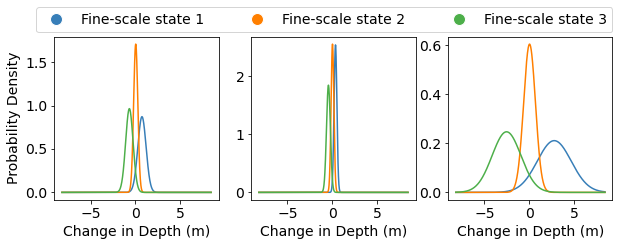

In [17]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

# define colors
coarse_colors = [CB_color_cycle[i+self.K[1]] for i in range(self.K[0])]
fine_colors = [CB_color_cycle[i] for i in range(self.K[1])]

K_total = self.K[1]*self.K[0]
perc = 0.95

fig,ax = plt.subplots(1,len(self.features)+1,figsize=(10,3))

x_labels = {"diveDuration" : "Dive Duration (s)",
            "maxDepth"     : "Maximum Depth (m)",
            "avg_bot_htv"  : "Average Bottom RHTV (rad/s)",
            "postDiveInt"  : "Post Dive Interval (seconds)",
            "w_low"        : "Wiggliness (low feq)",
            "w_high"       : "Wiggliness (high freq)",
            "delt_d"       : "Change in Depth (m)"}

for fignum,feature in enumerate(['delt_d']):#enumerate(self.features):
    
    # get bounds
    min_mu = np.min([theta_fine[feature]['mu'] for theta_fine in self.theta])
    max_mu = np.max([theta_fine[feature]['mu'] for theta_fine in self.theta])
    max_sig = np.exp(np.max([theta_fine[feature]['log_sig'] for theta_fine in self.theta]))
    
    x = np.linspace(min_mu-3*max_sig,max_mu+3*max_sig,1000)
    
    # see if we are using a truncnorm
    a = self.features[feature]["lower_bound"]
    b = self.features[feature]["upper_bound"]
    if not a is None:
        a = np.concatenate([self.features[feature]["lower_bound"] for _ in self.theta])
    if not b is None:
        b = np.concatenate([self.features[feature]["upper_bound"] for _ in self.theta])

    # now get the y values for each x
    y0 = np.zeros((1000,K_total))

    # true ys
    mu = np.concatenate([theta_fine[feature]['mu'] for theta_fine in self.theta])
    sig = np.exp(np.concatenate([theta_fine[feature]['log_sig'] for theta_fine in self.theta]))

    for state in range(K_total):
        if (not a is None) and (not b is None):
            y0[:,state] = truncnorm.pdf(x,a=(a[state]-mu[state])/sig[state],
                                          b=(b[state]-mu[state])/sig[state],
                                          loc=mu[state],scale=sig[state])
        else:
            y0[:,state] = norm.pdf(x,mu[state],sig[state])
    
    if feature == "maxDepth":
        ax[fignum].axvline(np.log(20),color='k',linestyle='--')
        ax[fignum].axvline(np.log(5),color='k',linestyle='--')
    
    for fignum,k0 in enumerate(range(self.K[0])):
        for k1 in range(self.K[1]):

            # define state:
            state = fignum*self.K[1] + k1
            
            # plot distribution
            ax[fignum].plot(x,y0[:,state],
                            color=fine_colors[k1])
        
        # add labels
        if fignum == 0:
            ax[fignum].set_ylabel("Probability Density",fontsize=14)

        ax[fignum].set_xlabel(x_labels[feature],fontsize=14)
        ax[fignum].tick_params(axis='both', which='major', labelsize=14)
        
leg_labels = ['Fine-scale state %d'%(i+1) for i in range(self.K[1])]

legend_elements = [Line2D([0], [0], marker='o', color='w', label=leg_labels[i],
                   markerfacecolor=fine_colors[i], markersize=12) for i in range(self.K[1])]

fig.legend(handles=legend_elements,
           prop={'size': 14}, 
           ncol=self.K[1], 
           mode="expand", 
           borderaxespad=0.,
           bbox_to_anchor=(0.1, 0.9, 0.8, .1),
           loc='lower left')

#fig.tight_layout()

fig.savefig(plot_folder+'/emission_dists_K_%d_%d_nWhales_%d.png' % (self.K[0],self.K[1],len(whales)),
            dpi=300,
            bbox_inches='tight')

In [63]:
self.theta

[{'delt_d': {'mu': array([ 0.74051803,  0.044094  , -0.6656825 ]),
   'log_sig': array([-0.78191974, -1.45397754, -0.88280862])},
  'e_dive': {'logit_p': array([-100.        , -100.        ,   -2.03996012])}},
 {'delt_d': {'mu': array([ 0.36032022,  0.02381687, -0.42845113]),
   'log_sig': array([-1.85237005, -1.85737121, -1.53312489])},
  'e_dive': {'logit_p': array([-100.        , -100.        ,   -0.10156359])}},
 {'delt_d': {'mu': array([ 2.79202869,  0.03702426, -2.529067  ]),
   'log_sig': array([ 0.63527761, -0.4173019 ,  0.47739288])},
  'e_dive': {'logit_p': array([-100.        , -100.        ,   -3.20408755])}}]

In [67]:
dive_type = 2
print(means['delt_d'] + stds['delt_d']*self.theta[dive_type-1]['delt_d']['mu'])
print(stds['delt_d']*np.exp(self.theta[dive_type-1]['delt_d']['log_sig']))

[ 0.33116812  0.00194615 -0.44053551]
[0.15347065 0.15270503 0.21118922]


In [19]:
self.eta

[array([[ 0.        ,  1.21056737, -2.60836261],
        [-1.9344494 ,  0.        , -3.58136119],
        [ 0.08308887,  2.52888757,  0.        ]]),
 [array([[   0.        ,   -1.95892792,   -4.90163291],
         [-100.        ,    0.        ,   -3.2281167 ],
         [-100.        , -100.        ,    0.        ]]),
  array([[   0.        ,   -0.78691594,   -3.15723098],
         [-100.        ,    0.        ,   -1.31503425],
         [-100.        , -100.        ,    0.        ]]),
  array([[   0.        ,   -3.17569359,   -6.15024995],
         [-100.        ,    0.        ,   -3.97696837],
         [-100.        , -100.        ,    0.        ]])]]

# Plot Dive Profiles

In [46]:
#sseg=5950
sseg=900

A100


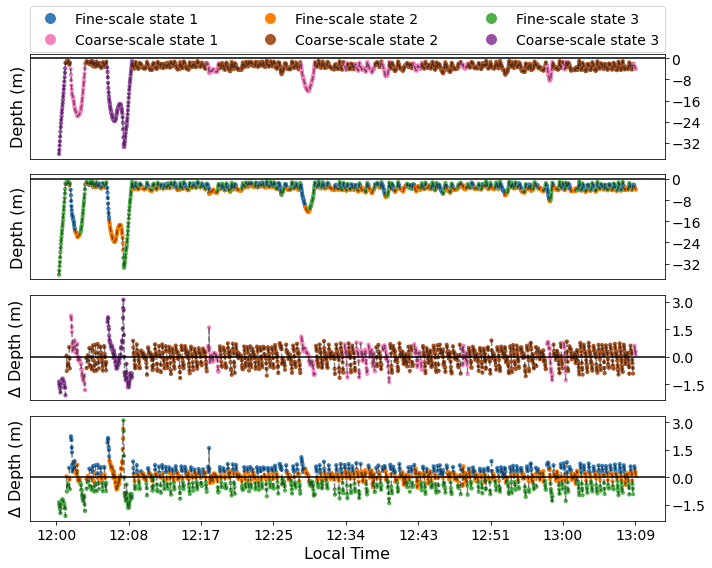

A113


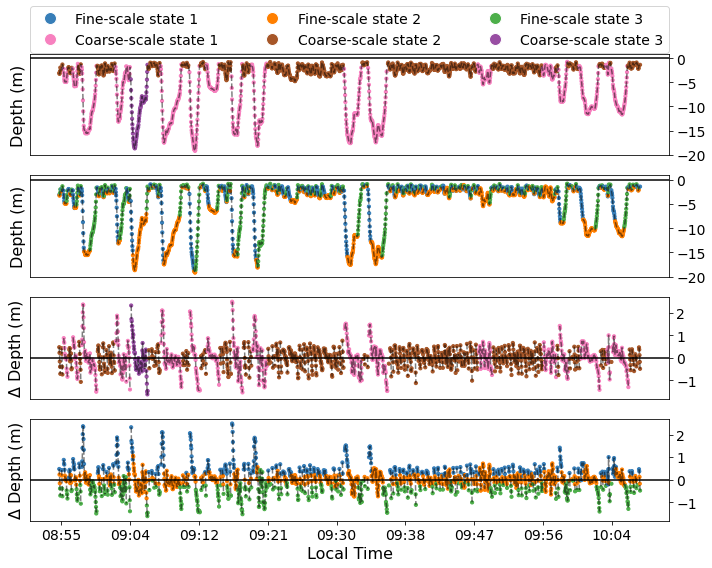

D21


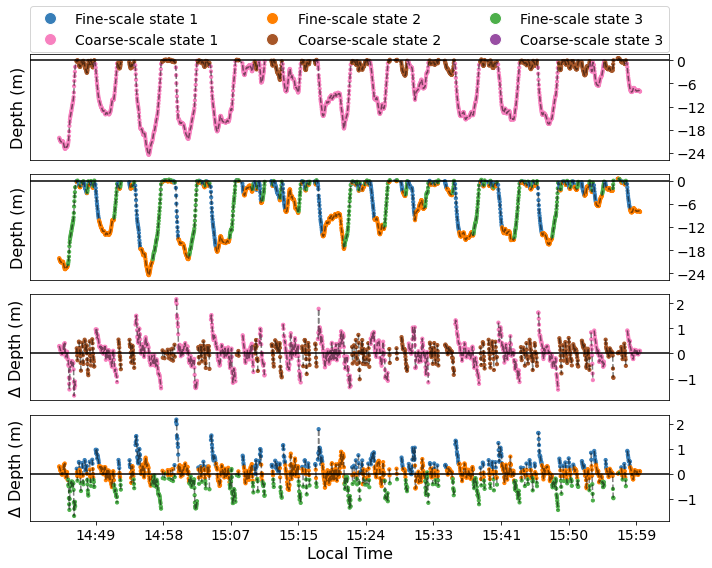

D26


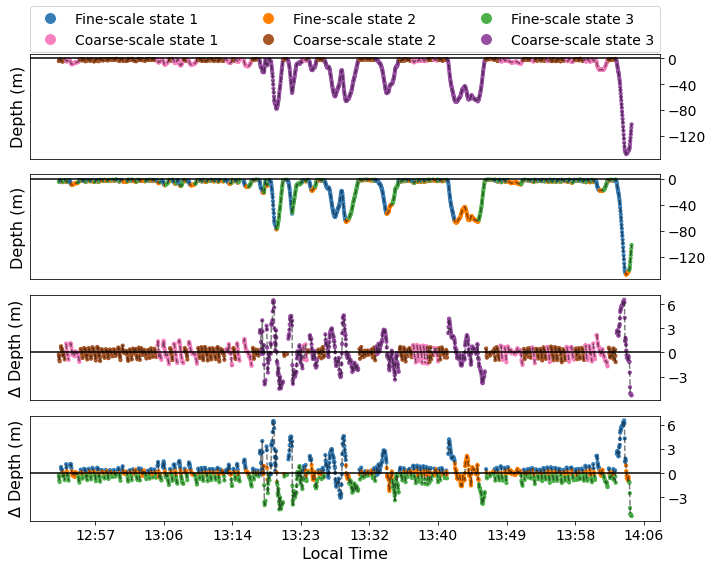

I107


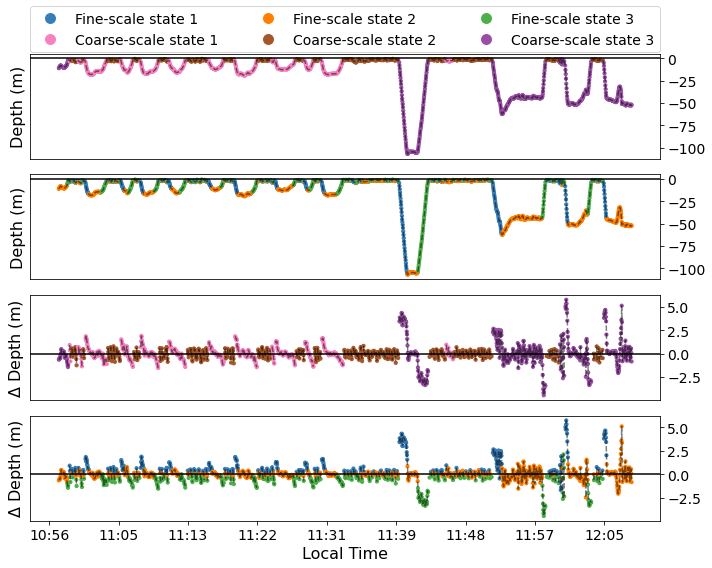

I145


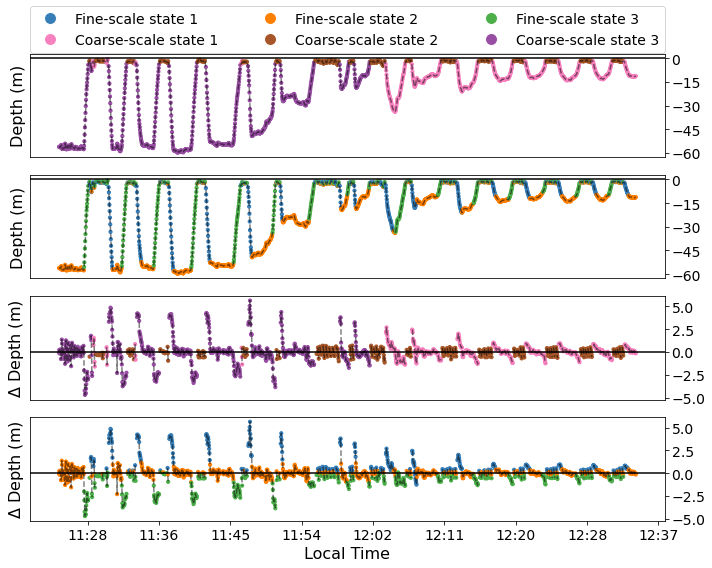

R48


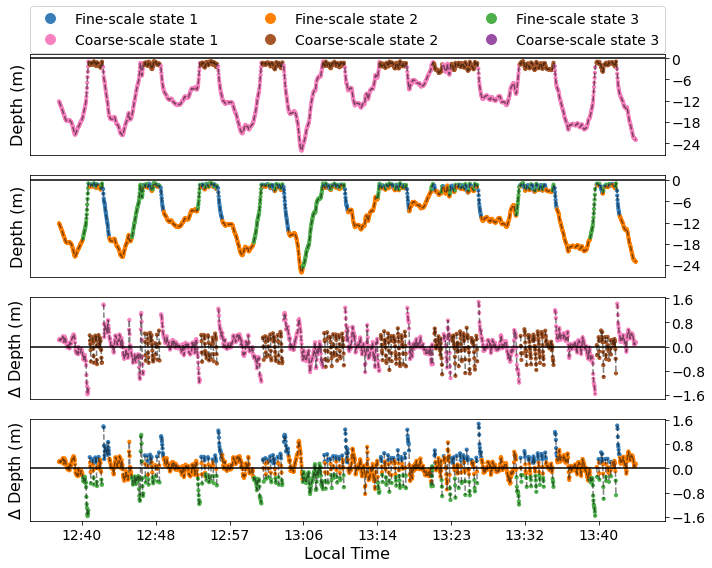

R58


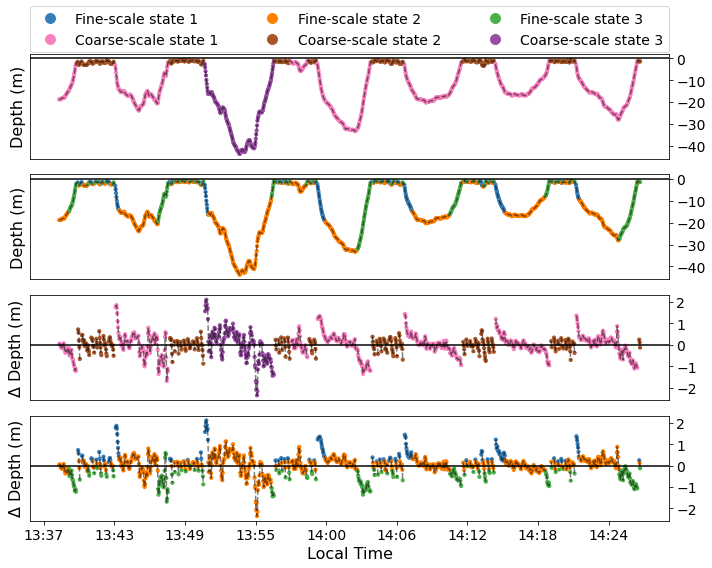

In [47]:
#sseg -= 500
eseg = sseg + 1800
size = 10
figsize = (10,8)

self.p_fine = np.zeros((self.T,self.K[1]))
self.p_coarse = np.zeros((self.T,self.K[0]))

# get p_coarse, p_fine, and CIs
for k0 in range(self.K[0]):
    self.p_coarse[:,k0] = np.sum(self.p_Xt[:,(k0*self.K[1]):((k0+1)*self.K[1])],1)

for k1 in range(self.K[1]):
    self.p_fine[:,k1] = np.sum(self.p_Xt[:,k1::self.K[1]],1)

for whale in whales:
    
    print(whale)

    df0 = df[df["ID"] == whale].reset_index().drop("index",axis=1).reset_index()
    df0 = df0[sseg:eseg]

    # get the dive types
    ML_subdivetype = np.argmax(self.p_fine[df["ID"] == whale,:],1)[sseg:eseg]
    ML_divetype = np.argmax(self.p_coarse[df["ID"] == whale,:],1)[sseg:eseg]

    # define colors
    coarse_colors = [CB_color_cycle[i+self.K[1]] for i in ML_divetype]
    fine_colors = [CB_color_cycle[i] for i in ML_subdivetype]

    fig,ax = plt.subplots(4,1,figsize=figsize)

    # get legend
    leg_labels = ['Dive Phase %d'%(i+1) for i in range(self.K[1])] + \
                 ['Dive Type %d'%(i+1) for i in range(self.K[0])]
    
    leg_labels = ['Fine-scale state %d'%(i+1) for i in range(self.K[1])] + \
                 ['Coarse-scale state %d'%(i+1) for i in range(self.K[1])]
    
    legend_elements = [Line2D([0], [0], marker='o', color='w', label=leg_labels[0],
                              markerfacecolor=CB_color_cycle[0], markersize=12),
                       Line2D([0], [0], marker='o', color='w', label=leg_labels[3],
                              markerfacecolor=CB_color_cycle[3], markersize=12),
                       Line2D([0], [0], marker='o', color='w', label=leg_labels[1],
                              markerfacecolor=CB_color_cycle[1], markersize=12),
                       Line2D([0], [0], marker='o', color='w', label=leg_labels[4],
                              markerfacecolor=CB_color_cycle[4], markersize=12),
                       Line2D([0], [0], marker='o', color='w', label=leg_labels[2],
                              markerfacecolor=CB_color_cycle[2], markersize=12),
                       Line2D([0], [0], marker='o', color='w', label=leg_labels[5],
                              markerfacecolor=CB_color_cycle[5], markersize=12)]

    #legend_elements = [Line2D([0], [0], marker='o', color='w', label=leg_labels[i],
    #                   markerfacecolor=CB_color_cycle[i], markersize=12) for i in range(self.K[1])] + \
    #                  [Line2D([0], [0], marker='o', color='w', label=leg_labels[i+self.K[1]],
    #                   markerfacecolor=CB_color_cycle[i+self.K[1]], markersize=12) for i in range(self.K[0])]


    ax[0].plot(df0['stime'],-df0['ad'],'k--',alpha=0.5)
    ax[0].axhline(0,color='k')
    ax[0].scatter(df0['stime'],-df0['ad'],c=coarse_colors,s=size)
    
    ax[1].plot(df0['stime'],-df0['ad'],'k--',alpha=0.5)
    ax[1].axhline(0,color='k')
    ax[1].scatter(df0['stime'],-df0['ad'],c=fine_colors,s=size)
    
    ax[2].plot(df0['stime'],df0['delt_d'],'k--',alpha=0.5)
    ax[2].axhline(0,color='k')
    ax[2].scatter(df0['stime'],df0['delt_d'],c=coarse_colors,s=size)
    
    ax[3].plot(df0['stime'],df0['delt_d'],'k--',alpha=0.5)
    ax[3].axhline(0,color='k')
    ax[3].scatter(df0['stime'],df0['delt_d'],c=fine_colors,s=size)

    # position legend
    ax[0].legend(handles=legend_elements,prop={'size': 14}, ncol=3, mode="expand", borderaxespad=0.,
                 bbox_to_anchor=(0., 1.01, 1., .102), loc='lower left')

    for ax0 in ax:
        ax0.set_xticks([])

    ax[0].set_ylabel('Depth (m)',fontsize=16)
    ax[2].set_ylabel(r'$\Delta$ Depth (m)',fontsize=16)

    ax[1].set_ylabel('Depth (m)',fontsize=16)
    ax[3].set_ylabel(r'$\Delta$ Depth (m)',fontsize=16)

    ax[-1].set_xlabel("Local Time",fontsize=16)
    ax[-1].xaxis.set_major_locator(plt.MaxNLocator(10))
    ax[-1].xaxis.set_major_formatter(DateFormatter('%H:%M'))

    for ax0 in ax:
        ax0.yaxis.set_major_locator(plt.MaxNLocator(5))
        ax0.yaxis.tick_right()
        for item in ax0.get_yticklabels():
            item.set_fontsize(14)
        for item in ax0.get_xticklabels():
            item.set_fontsize(14)

    plt.tight_layout()
    plt.savefig(plot_folder+'/decoded_dives_kw_%s_K_%d_%d_nWhales_%d.png'%(whale,self.K[0],self.K[1],len(whales)),dpi=300)
    plt.show()

In [22]:
df[df["ID"] == 'I107']

,index,ID,level,jp,rajp,htv,ptv,rtv,ad,aw1,...,bottom,stime,etime,label,divenum,abs_roll,diveDuration,delt_d,elev,e_dive
54963,54963,I107,2,-inf,NaN,NaN,NaN,NaN,3.461686,NaN,...,False,2020-08-25 10:21:01.830,2020-08-25 10:21:03.810,0,3616,NaN,5.409322,NaN,-3.461686,False
54964,54964,I107,2,-inf,NaN,NaN,NaN,NaN,3.479138,NaN,...,False,2020-08-25 10:21:03.830,2020-08-25 10:21:05.810,0,3616,NaN,NaN,0.039666,-3.479138,False
54965,54965,I107,2,434.813834,-1.943249,1.787597,0.758410,1.143876,3.703848,-0.048119,...,False,2020-08-25 10:21:05.880,2020-08-25 10:21:07.810,0,3616,0.279089,NaN,0.251507,-3.703848,False
54966,54966,I107,2,3.172532,-0.907502,0.177010,0.109101,0.212735,5.267373,-0.006024,...,False,2020-08-25 10:21:07.830,2020-08-25 10:21:09.810,0,3616,0.687652,NaN,1.619934,-5.267373,False
54967,54967,I107,2,1.363014,-0.343816,0.169866,0.106891,0.116378,7.003610,-0.003696,...,False,2020-08-25 10:21:09.830,2020-08-25 10:21:11.810,0,3616,0.413131,NaN,1.796464,-7.003610,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72212,72212,I107,2,3.366086,0.018980,0.062968,0.040912,0.017065,3.519991,-0.001297,...,True,2020-08-25 22:36:13.330,2020-08-25 22:36:15.310,0,4993,0.016977,NaN,0.140303,-3.519991,False
72213,72213,I107,2,2.072077,0.008220,0.063947,0.035132,0.015288,3.214695,-0.001428,...,True,2020-08-25 22:36:15.330,2020-08-25 22:36:17.310,0,4993,0.014390,NaN,-0.290221,-3.214695,False
72214,72214,I107,2,2.582461,0.001191,0.074106,0.030372,0.037061,2.635250,-0.002338,...,True,2020-08-25 22:36:17.330,2020-08-25 22:36:19.310,0,4993,0.025809,NaN,-0.570433,-2.635250,False
72215,72215,I107,2,3.134839,-0.065371,0.079602,0.029535,0.028468,1.897268,-0.007382,...,False,2020-08-25 22:36:19.330,2020-08-25 22:36:21.310,0,4993,0.044525,NaN,-0.732476,-1.897268,False


In [23]:
sseg

5950

In [24]:
self.theta

[{'delt_d': {'mu': array([ 0.74051803,  0.044094  , -0.6656825 ]),
   'log_sig': array([-0.78191974, -1.45397754, -0.88280862])},
  'e_dive': {'logit_p': array([-100.        , -100.        ,   -2.03996012])}},
 {'delt_d': {'mu': array([ 0.36032022,  0.02381687, -0.42845113]),
   'log_sig': array([-1.85237005, -1.85737121, -1.53312489])},
  'e_dive': {'logit_p': array([-100.        , -100.        ,   -0.10156359])}},
 {'delt_d': {'mu': array([ 2.79202869,  0.03702426, -2.529067  ]),
   'log_sig': array([ 0.63527761, -0.4173019 ,  0.47739288])},
  'e_dive': {'logit_p': array([-100.        , -100.        ,   -3.20408755])}}]

In [25]:
self.eta

[array([[ 0.        ,  1.21056737, -2.60836261],
        [-1.9344494 ,  0.        , -3.58136119],
        [ 0.08308887,  2.52888757,  0.        ]]),
 [array([[   0.        ,   -1.95892792,   -4.90163291],
         [-100.        ,    0.        ,   -3.2281167 ],
         [-100.        , -100.        ,    0.        ]]),
  array([[   0.        ,   -0.78691594,   -3.15723098],
         [-100.        ,    0.        ,   -1.31503425],
         [-100.        , -100.        ,    0.        ]]),
  array([[   0.        ,   -3.17569359,   -6.15024995],
         [-100.        ,    0.        ,   -3.97696837],
         [-100.        , -100.        ,    0.        ]])]]

In [26]:
plot_folder+'/decoded_dives_kw_%s_K_%d_%d_nWhales_%d.png'%(whale,self.K[0],self.K[1],len(whales))

'/Users/evsi8432/Documents/Research/sublinear-HMM-inference/plt/case_study/updown/2023-04-14/decoded_dives_kw_I107_K_3_3_nWhales_8.png'

A100
100
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380


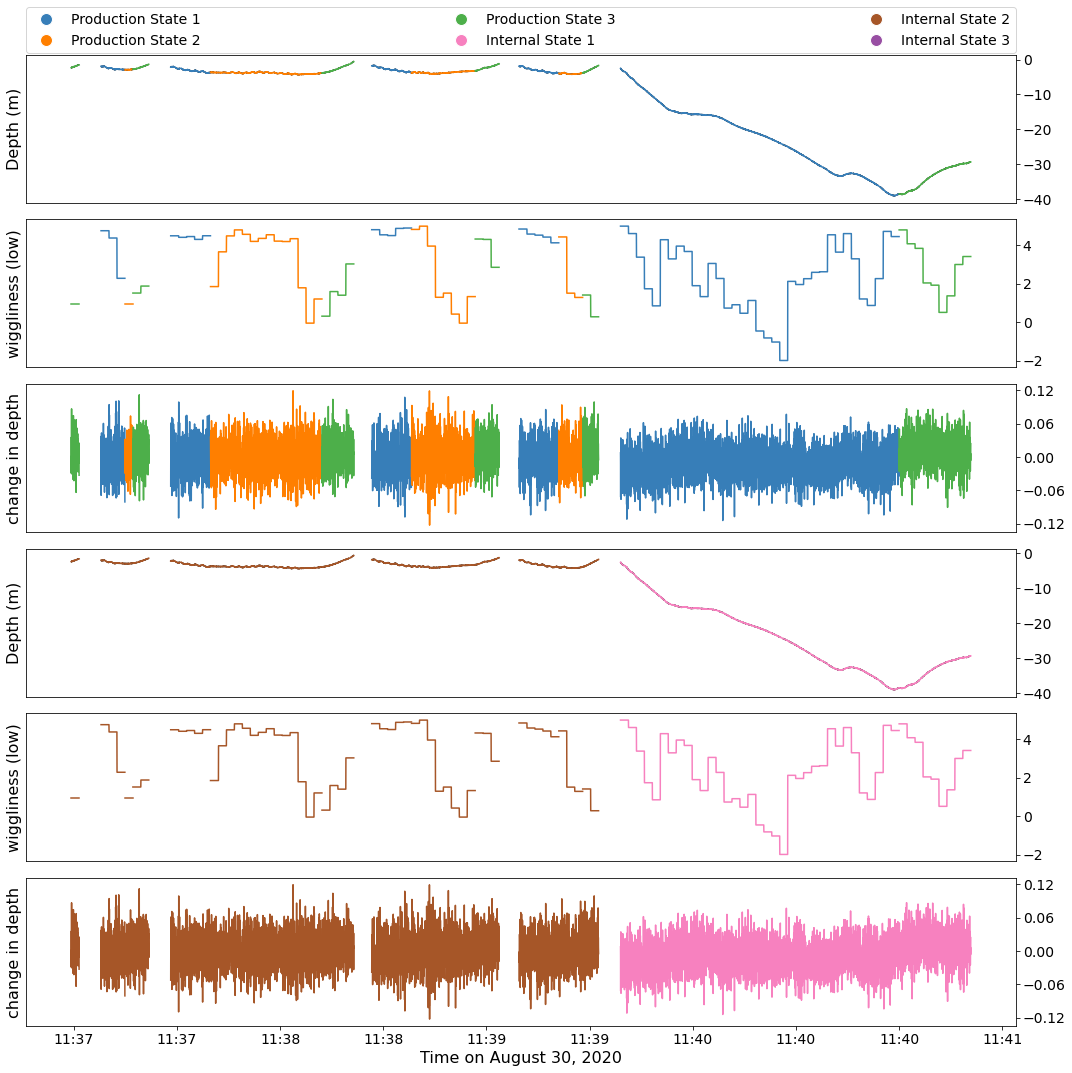

A113
100
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380


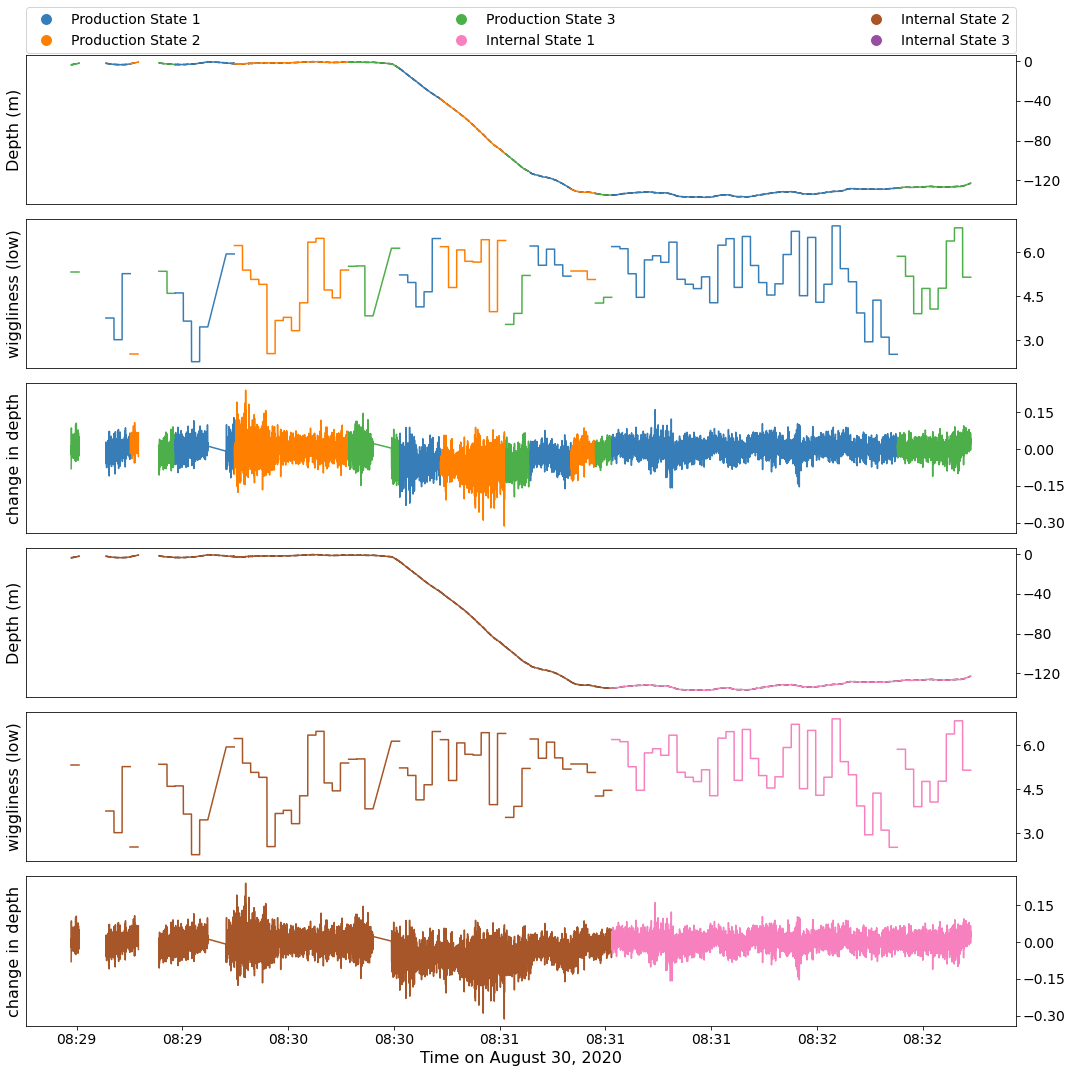

D21
100
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380


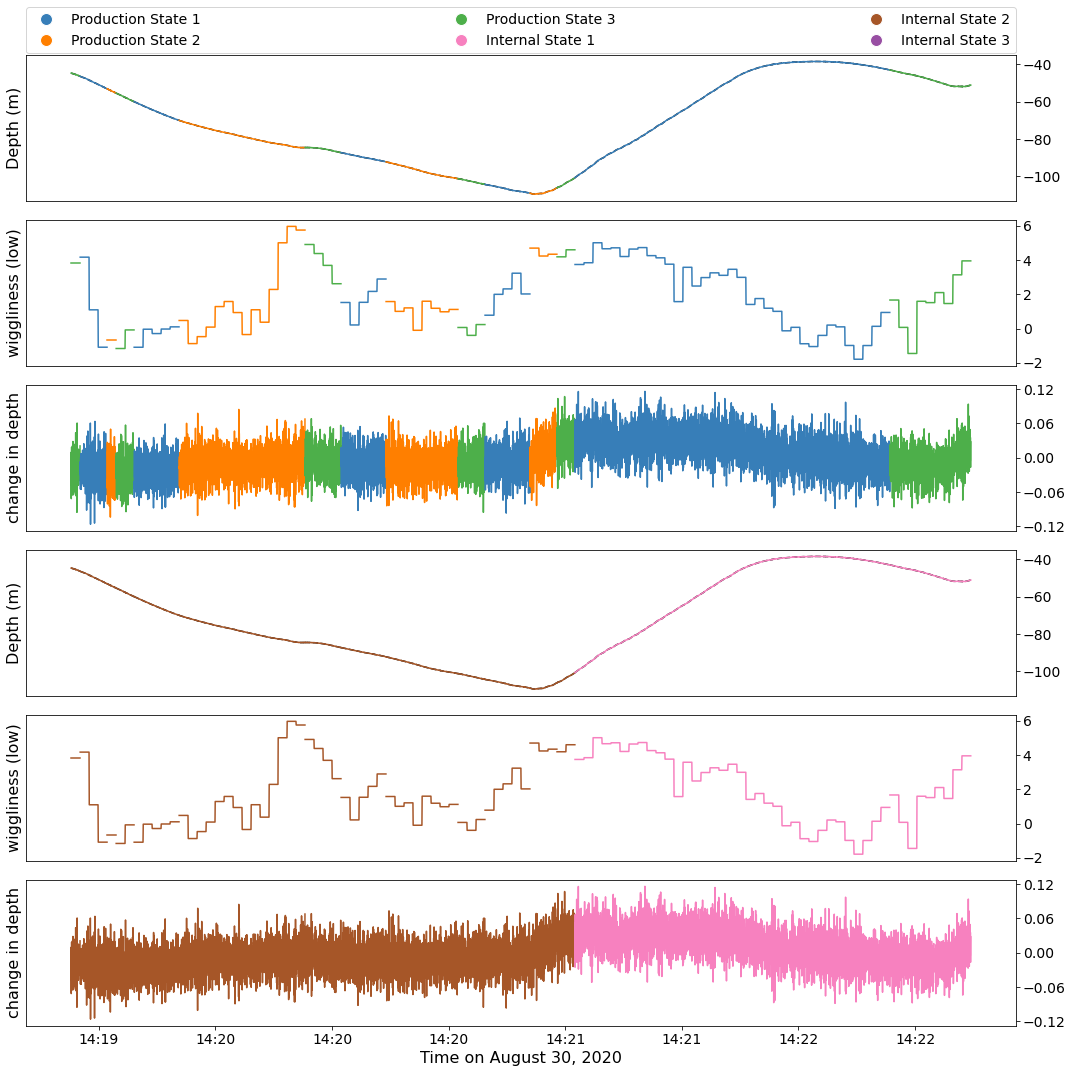

D26
100
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380


KeyboardInterrupt: 

In [27]:
for whale in whales:
    
    print(whale)

    df0 = df[df["ID"] == whale].reset_index().drop("index",axis=1).reset_index()
    ind = 280#min(df0[df0.ID == whale]["index"])
    span = 100#len(df0[df0.ID == whale]) - 2
    
    # get delta d
    df0["delt_d"] = df0["ad"].diff()
    raw_df["delt_d"] = raw_df["Elevation"].diff()
    
    print(span)

    # get the dive types
    ML_divetype = np.argmax(self.p_fine,1)
    ML_bouttype = np.argmax(self.p_coarse,1)

    # define colors
    coarse_colors = [CB_color_cycle[i+self.K[1]] for i in range(self.K[0])]
    fine_colors = [CB_color_cycle[i] for i in range(self.K[1])]

    fig,ax = plt.subplots(6,1,figsize=(15,15))

    # get legend
    labels = ['Production State 1','Production State 2','Production State 3',
              'Internal State 1','Internal State 2']
    legend_elements = [Line2D([0], [0], marker='o', color='w', label=labels[0],
                                      markerfacecolor=fine_colors[0], markersize=12),
                       Line2D([0], [0], marker='o', color='w', label=labels[1],
                                      markerfacecolor=fine_colors[1], markersize=12),
                       Line2D([0], [0], marker='o', color='w', label=labels[2],
                                      markerfacecolor=fine_colors[2], markersize=12),
                       Line2D([0], [0], marker='o', color='w', label=labels[3],
                                      markerfacecolor=coarse_colors[0], markersize=12),
                       Line2D([0], [0], marker='o', color='w', label=labels[4],
                                      markerfacecolor=coarse_colors[1], markersize=12)]
                       #Patch(facecolor=coarse_colors[0], alpha=0.5, label=labels[4]),
                       #Patch(facecolor=coarse_colors[1], alpha=0.5, label=labels[5])]

    leg_labels = ['Production State %d'%(i+1) for i in range(self.K[1])] + \
                 ['Internal State %d'%(i+1) for i in range(self.K[0])]

    legend_elements = [Line2D([0], [0], marker='o', color='w', label=leg_labels[i],
                       markerfacecolor=fine_colors[i], markersize=12) for i in range(self.K[1])] + \
                      [Line2D([0], [0], marker='o', color='w', label=leg_labels[i+self.K[1]],
                       markerfacecolor=coarse_colors[i], markersize=12) for i in range(self.K[0])]
    
    fine_df = raw_df[raw_df["Time"] <= df0["etime"].iloc[ind]]
    fine_df = fine_df[fine_df["Time"] >= df0["stime"].iloc[ind]]
    fine_df = fine_df[fine_df["ID"] == whale]
    
    coarse_df = raw_df[raw_df["Time"] <= df0["etime"].iloc[ind]]
    coarse_df = coarse_df[coarse_df["Time"] >= df0["stime"].iloc[ind]]
    coarse_df = coarse_df[coarse_df["ID"] == whale]

    for divenum in range(ind+1,ind+span+1):

        print(divenum)

        dive_df = raw_df[raw_df["Time"] <= df0["etime"].iloc[divenum]]
        dive_df = dive_df[dive_df["Time"] >= df0["stime"].iloc[divenum]]
        dive_df = dive_df[dive_df["ID"] == whale]
        
        # plot dive profiles
        if (ML_divetype[divenum] != ML_divetype[divenum-1]) or \
           (ML_bouttype[divenum] != ML_bouttype[divenum-1]) or \
           (divenum == ind+span):
                    
            ax[0].plot(pd.to_datetime(fine_df["Time"]),
                       fine_df["Elevation"],
                       "k--")

            ax[0].plot(pd.to_datetime(fine_df["Time"]),
                       fine_df["Elevation"],
                       color=fine_colors[ML_divetype[divenum-1]])
            
            ax[1].plot(pd.to_datetime(fine_df["Time"]),
                       np.log(fine_df["w_low"]),
                       color=fine_colors[ML_divetype[divenum-1]])
            
            ax[2].plot(pd.to_datetime(fine_df["Time"]),
                       fine_df["delt_d"],
                       color=fine_colors[ML_divetype[divenum-1]])
            
            fine_df = dive_df
        
        else:
            
            fine_df = pd.concat([fine_df,dive_df])
            
        if (ML_bouttype[divenum] != ML_bouttype[divenum-1]) or \
           (ML_divetype[divenum] != ML_divetype[divenum-1]) or \
           (divenum == ind+span):
            
            ax[3].plot(pd.to_datetime(coarse_df["Time"]),
                       coarse_df["Elevation"],
                       "k--")
            
            ax[3].plot(pd.to_datetime(coarse_df["Time"]),
                       coarse_df["Elevation"],
                       color=coarse_colors[ML_bouttype[divenum-1]])

            ax[4].plot(pd.to_datetime(coarse_df["Time"]),
                       np.log(coarse_df["w_low"]),
                       color=coarse_colors[ML_bouttype[divenum-1]])

            ax[5].plot(pd.to_datetime(coarse_df["Time"]),
                       coarse_df["delt_d"],
                       color=coarse_colors[ML_bouttype[divenum-1]])
            
            coarse_df = dive_df
            
        else:
            
            coarse_df = pd.concat([coarse_df,dive_df])

    # position legend
    ax[0].legend(handles=legend_elements,prop={'size': 14}, ncol=3, mode="expand", borderaxespad=0.,
                 bbox_to_anchor=(0., 1.01, 1., .102), loc='lower left')

    for ax0 in ax:
        ax0.set_xticks([])

    ax[0].set_ylabel('Depth (m)',fontsize=16)
    ax[1].set_ylabel('wiggliness (low)',fontsize=16)
    ax[2].set_ylabel('change in depth',fontsize=16)

    ax[3].set_ylabel('Depth (m)',fontsize=16)
    ax[4].set_ylabel('wiggliness (low)',fontsize=16)
    ax[5].set_ylabel('change in depth',fontsize=16)

    ax[0].yaxis.set_major_locator(plt.MaxNLocator(5))
    ax[1].yaxis.set_major_locator(plt.MaxNLocator(5))
    ax[2].yaxis.set_major_locator(plt.MaxNLocator(5))
    ax[3].yaxis.set_major_locator(plt.MaxNLocator(5))
    ax[4].yaxis.set_major_locator(plt.MaxNLocator(5))
    ax[5].yaxis.set_major_locator(plt.MaxNLocator(5))

    ax[-1].set_xlabel("Time on August 30, 2020",fontsize=16)
    ax[-1].xaxis.set_major_locator(plt.MaxNLocator(10))
    ax[-1].xaxis.set_major_formatter(DateFormatter('%H:%M'))

    for ax0 in ax:
        ax0.yaxis.tick_right()
        for item in ax0.get_yticklabels():
            item.set_fontsize(14)
        for item in ax0.get_xticklabels():
            item.set_fontsize(14)

    plt.tight_layout()
    plt.savefig(plot_folder+'/decoded_dives_kw_%s_K_%d_%d_nWhales_%d.png'%(whale,self.K[0],self.K[1],len(whales)),dpi=300)
    plt.show()